In [1]:
include("../scripts/kf.jl")

┌ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
└ @ Base loading.jl:1278


draw (generic function with 8 methods)

In [2]:
function make_ax()
    fig, ax = subplots()
    ax.set_aspect("equal")
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_xlabel("X", fontsize=20)
    ax.set_ylabel("Y", fontsize=20)
    return ax
end

make_ax (generic function with 1 method)

In [3]:
function draw_trajectory(xs, ax)
    poses = [xs[s] for s in 1:length(xs)]
    ax.scatter([e[1] for e in poses], [e[2] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[1] for e in poses], [e[2] for e in poses], linewidth=0.5, color="black")
end

draw_trajectory (generic function with 1 method)

In [4]:
function draw_observations(xs, zlist, ax)
    for s in 1:length(xs)
        if !haskey(zlist, s)
            continue
        end
        for obs in zlist[s]
            x,y,theta = xs[s]
            ell,phi = obs[2][1], obs[2][2]
            mx = x + ell*cos(theta+phi)
            my = y + ell*sin(theta+phi)
            ax.plot([x,mx],[y,my], color="pink", alpha=0.5)
        end
    end
end

draw_observations (generic function with 1 method)

In [5]:
function read_data()
    f = open("log_for_book.txt", "r")
    lines = readlines(f)
    hat_xs = Dict()
    zlist = Dict()
    for line in lines
        tmp = split(line)
        step = parse(Int, tmp[2]) + 1#for 1-indexed
        if tmp[1] == "x"
            hat_xs[step] = [parse(Float64, tmp[3]), 
                parse(Float64, tmp[4]), parse(Float64, tmp[5])]
        elseif tmp[1] == "z"
            if !haskey(zlist, step)
                zlist[step] = []
            end
            push!(zlist[step], (parse(Int, tmp[3]), [parse(Float64, tmp[4]), 
                parse(Float64, tmp[5]), parse(Float64, tmp[6])]))
        end
    end
    return hat_xs, zlist
end

read_data (generic function with 1 method)

In [6]:
mutable struct ObsEdge
    t1
    t2
    x1
    x2
    z1
    z2
end

In [33]:
function ObsEdge_(t1,t2,z1,z2,xs)
    @assert z1[1] == z2[1]
    self = ObsEdge(ntuple(x->nothing, fieldcount(ObsEdge))...)
    self.t1, self.t2 = t1, t2
    self.x1, self.x2 = xs[t1], xs[t2]
    self.z1, self.z2 = z1[2], z2[2]
    
    s1 = sin(self.x1[3] + self.z1[2])
    c1 = cos(self.x1[3] + self.z1[2])
    s2 = sin(self.x2[3] + self.z2[2])
    c2 = cos(self.x2[3] + self.z2[2])
    
    hat_e = self.x2 - self.x1 + [self.z2[1]*c2 - self.z1[1]*c1, 
        self.z2[1]*s2 - self.z1[1]*s1, 
        self.z2[2] - self.z2[3] - self.z1[2] + self.z1[3]]
    
    while hat_e[3] >= pi
        hat_e[3] -= 2*pi
    end
    while hat_e[3] < -pi
        hat_e[3] += 2*pi
    end
    println(hat_e)
    
    return self
end

ObsEdge_ (generic function with 1 method)

In [34]:
function make_edges(hat_xs, zlist)
    landmark_keys_zlist = Dict()
    for step in keys(zlist)
        for z in zlist[step]
            landmark_id = z[1]
            if !haskey(landmark_keys_zlist,landmark_id)
                landmark_keys_zlist[landmark_id] = []
            end
            push!(landmark_keys_zlist[landmark_id],(step,z))
        end
    end

    edges = []
    for landmark_id in keys(landmark_keys_zlist)
        for i in 1:length(landmark_keys_zlist[landmark_id])
            for j in i+1:length(landmark_keys_zlist[landmark_id])
                xz1 = landmark_keys_zlist[landmark_id][i]
                xz2 = landmark_keys_zlist[landmark_id][j]
                push!(edges, ObsEdge_(xz1[1], xz2[1], xz1[2], xz2[2], hat_xs))
            end
        end
    end
    return edges
end

make_edges (generic function with 1 method)

In [35]:
function draw_edges(edges, ax)
    for e in edges
        ax.plot([e.x1[1], e.x2[1]], [e.x1[2], e.x2[2]], color="red", alpha=0.5)
    end
end

draw_edges (generic function with 1 method)

In [36]:
function draw(xs, zlist, edges)
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_edges(edges, ax)
    draw_trajectory(xs, ax)
end

draw (generic function with 9 methods)

[5.728145363731871, -8.655102606031644, -2.3561944901923546]
[5.310939112365007, -1.828961724413014, -1.0471975511966019]
[3.5336720632504792, -10.562561350152203, -2.879793265790653]
[4.75646956734537, -9.753285923540538, -2.6179938779915037]
[4.212755794856107, -0.8572859280265184, -0.7853981633974527]
[6.382481352656422, -7.3428507758800095, -2.0943951023932055]
[-1.390587582667631, -0.46521675278173835, 0.2617993877991496]
[1.4636114155362148, 0.08945432605675885, -0.2617993877991496]
[6.120214538976677, -3.0517592285079, -1.308996938995751]
[6.58543129175841, -4.44234681117553, -1.5707963267949]
[-1.4764399877705054, 7.820274535293409, 1.3089969389957528]
[-2.2556442668817502, -2.5220385260506157, -0.5235987755982983]
[-0.9618057979577764, -1.409499863727144, -0.26179938779914913]
[-2.885939851497655, 8.782080333251177, 1.5707963267949019]
[0.5642276513199899, 1.6104059787264706, 0.26179938779914913]
[-9.412375917867084, 8.41817900780412, 2.6179938779915037]
[-6.197911417821461, 9

[2.197550523535785, 3.576626543098995, 1.5707963267949019]
[0.8643648674105866, 5.416145415714484, 2.356194490192353]
[2.2776409365862587, 2.8058976078537654, 1.3089969389957528]
[0.8643648674105955, 5.416145415714479, 2.3561944901923493]
[0.7237380593940539, 0.2768407254566605, 0.26179938779914913]
[-2.0893126543608442, -3.8469539268953943, -2.0943951023932037]
[0.06586361544616004, -2.5266095751559523, -1.0471975511965974]
[-2.0893126543608256, -3.8469539268953934, -2.0943951023931966]
[-1.437622225046019, -3.743815035275052, -1.8325957145940475]
[0.26829441372862745, -0.6027903069784729, -0.26179938779914935]
[-0.32202089668790745, -3.060354506627637, -1.3089969389957492]
[0.37143330534896957, -1.2544807362932797, -0.5235987755982987]
[-0.8348319180675463, -3.4755206215464254, -1.5707963267948983]
[0.37143330534897, -1.254480736293288, -0.5235987755983018]
[-3.361441493223513, -3.541384236992574, -2.617993877991502]
[2.4058841083541345, 1.6172498091469443, 1.0471975511966054]
[2.109

[1.0734762791700918, -0.8625507711641287, -0.26179938779914935]
[1.0734762791701045, -0.8625507711641425, -0.2617993877991527]
[-1.4881932898746268, -9.632842477681947, -2.356194490192353]
[1.5931700403370996e-14, -8.43769498715119e-15, -2.6645352591003757e-15]
[0.546863365519278, -8.882535163044718, -2.0943951023932037]
[-8.177419601368008, -5.513676856432729, -2.0943951023932]
[5.147850367509005, -2.239980786471653, -2.3561944901923546]
[2.9482621906881255, 0.7342496825449563, -1.0471975511966019]
[2.163845646739692, 0.8516952814797638, -0.7853981633974487]
[-0.9278304212116988, -2.132309439289554, 0.7853981633974487]
[1.375760290603705, 0.7621170778075277, -0.5235987755983036]
[4.713939090511724, -3.751688371020472, -2.879793265790653]
[5.030404768574195, -3.0243973304200766, -2.6179938779915037]
[-0.8103848222768959, -1.3478928953411278, 0.5235987755982991]
[2.1638456467397016, 0.8516952814797611, -0.7853981633974527]
[5.058272163836776, -1.451895430335656, -2.0943951023932055]
[0.

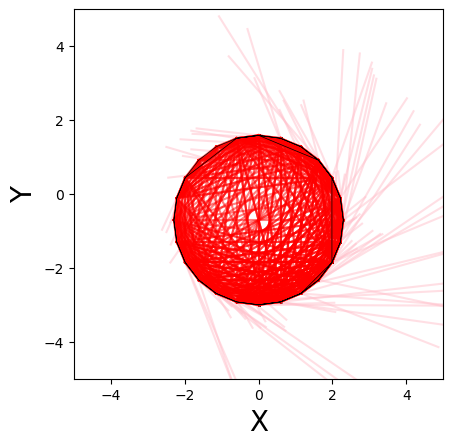

, 0.6373988018592893, -0.26179938779915624]
[1.121364399393497, 2.7852342781735384, -1.3089969389957528]
[-0.09037219065238411, 0.6373988018592749, -0.26179938779914913]
[1.1638395999622755, -1.4859136059727038, 0.7853981633974474]
[0.2522637821761651, -0.5922899202731093, 0.26179938779914913]
[1.1638395999622906, -1.4859136059727125, 0.7853981633974545]
[4.13660544004852, -1.0644265236601678, 2.0943951023932]
[3.03749806034971, -1.713654319666591, 1.5707963267949019]
[0.6145469399677908, 2.388270264343289, -1.0471975511966036]
[-0.012694074335128702, 1.2764688103093476, -0.5235987755983054]
[0.6492277960064305, -1.0991073796988258, 0.5235987755983054]
[-0.4277302445836213, 4.911934954417299, -2.6179938779915055]
[-1.1971234597056193, 0.5588193534779, -0.5235987755983054]
[2.9574818438792554, 2.0690630841525897, 1.5707963267948966]
[-2.098395249152623, 2.2918629970867404, -1.3089969389957599]
[-1.018839157643689, 4.604527931059056, -2.3561944901923564]
[-2.0983952491526208, 2.291862997

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9006fcbca0>

In [37]:
hat_xs, zlist = read_data()
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)